<a href="https://colab.research.google.com/github/AAhmadS/NLP_HW4/blob/main/Token_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install torchtext==0.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 108.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.2 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1


In [ ]:
import pandas as pd
import numpy as np
from numpy import pad
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import matplotlib.ticker as ticker
import torch
from torch import nn
import torchtext
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset
from collections import Counter
from torchtext.data.utils import get_tokenizer
import nltk
from nltk.tokenize import sent_tokenize
from transformers import pipeline, AutoTokenizer
from __future__ import unicode_literals, print_function, division
from torch import optim
import torch.nn.functional as F
import random

from tqdm import tqdm

#Section 1 : Loading data and preprocessing


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
with open("ferdousi.txt","r") as fle:
  file = fle.read().splitlines()[2:]

In [ ]:
sentences = [tokenizer.tokenize(x) for x in file]

In [ ]:
tokenized = [tokenizer.convert_tokens_to_ids(x) for x in sentences]

In [ ]:
sentences[0]

['▁به', '▁نام', '▁خداوند', '▁جان', '▁و', '▁خرد']

In [ ]:
max_len=0
max_num=0
for x in tokenized:
  if(max_len<len(x)):max_len = len(x)
  if(max(x)>max_num):
    max_num = max(x)
print(max_len, max_num)

14 24999


In [ ]:
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'Using {device} for inference')
device=torch.device("cpu")

Using cuda for inference


In [ ]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {'[BOP]':10, '<unk>':0, tokenizer.eos_token : tokenizer.eos_token_id, tokenizer.bos_token : tokenizer.bos_token_id}
        self.word2count = {}
        self.index2word = {tokenizer.bos_token_id: tokenizer.bos_token, tokenizer.eos_token_id: tokenizer.eos_token, 10:'[BOP]', 0:'<unk>'}
        self.n_words = 25000

    def addSentence(self, sentences, tokenized):
        for i in range(len(sentences)):
          for j in range(len(sentences[i])):
            self.addWord(sentences[i][j],tokenized[i][j])

    def addWord(self, word, index):
        if word not in self.word2index:
            self.word2index[word] = index
            self.word2count[word] = 1
            self.index2word[index] = word
        else:
            self.word2count[word] += 1

In [ ]:
po_persian = Lang("persian")
po_persian.addSentence(sentences,tokenized)

In [ ]:
input_lang = po_persian
output_lang = po_persian
SB_token = '[BOP]'
SB_token_id = 10
WSpace_token_id=0
sentences
tokenized
Global_pad_arg = 14

def indexesFromSentence(lang, sentence_ind):
    return [lang.word2index[word] for word in sentences[sentence_ind]]


def tensorFromSentence(lang, sentence_ind, pad_arg):
    indexes = [SB_token_id]
    indexes+= (indexesFromSentence(lang, (sentence_ind)%99217))
    indexes+=(indexesFromSentence(lang,(sentence_ind+1)%99217))
    indexes.append(tokenizer.eos_token_id)

    while len(indexes)<pad_arg+1:
      indexes.append(WSpace_token_id)
    return torch.tensor(indexes, dtype=torch.int32).view(-1, 1)


def tensorsFromPair(pair_ind):
    input_tensor = tensorFromSentence(input_lang, 2*pair_ind, 26)
    target_tensor = tensorFromSentence(output_lang,2*pair_ind+2, 26)
    return np.array(input_tensor), np.array(target_tensor)

In [ ]:
listt = np.arange(49600)
random.shuffle(listt)
listt
X = []
y = []
for x in listt[:int(0.8*len(listt))]:
  t,u = tensorsFromPair(x)
  X.append(t)
  y.append(u)
X = np.array(X)
y = np.array(y)

In [ ]:
X = X.reshape((39680,27))
y = y.reshape((39680,27))

X = torch.from_numpy(X)
y = torch.from_numpy(y)

train_dataset = TensorDataset(X, y)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

#Section 2 : LSTM model

##Training Subsection:

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout_p):
    super(Encoder, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.dropout = nn.Dropout(dropout_p)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout_p)

  def forward(self, input,hidden,cell):
    embedding = self.dropout(self.embedding(input)).view(1, 1, -1)
    output, (hidden, cell) = self.lstm(embedding,(hidden,cell))

    return hidden, cell

  def initHidden(self, batch_size):
    return (torch.zeros((self.num_layers, batch_size,self.hidden_size),device= device), torch.zeros((self.num_layers, batch_size, self.hidden_size),device=device))

class Decoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout_p):
    super(Decoder, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.dropout = nn.Dropout(dropout_p)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout_p)
    self.fc = nn.Linear(hidden_size, input_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden, cell):
    input = input.unsqueeze(0)

    embedding = self.dropout(self.embedding(input)).view(1, 1, -1)
    embedding = F.relu(embedding)
    output, (hidden, cell) = self.lstm(embedding,(hidden,cell))
    prediction = self.softmax(self.fc(output[0]))
    #prediction = prediction.squeeze(0)

    return prediction, hidden, cell


In [ ]:
teacher_force_ratio = 0.5
MAX_LENGTH=27

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH, batch_size=1):
    encoder_hidden,encoder_cell = encoder.initHidden(batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    batch_size = input_tensor.shape[1]
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_hidden, encoder_cell = encoder(
            input_tensor[ei], encoder_hidden, encoder_cell)
        if input_tensor[ei].item() == 0:
            break

    x = torch.tensor([[tokenizer.bos_token_id]], device=device)

    hidden = encoder_hidden
    cell = encoder_cell

    for t in range(1, target_length):
      output, hidden, cell = decoder(x, hidden, cell)
      loss += criterion(output, target_tensor[t])
      best_guess = output.argmax(dim=1)
      x = target_tensor[t] if random.random()<teacher_force_ratio else best_guess
      if x.item() == tokenizer.eos_token_id:
        break


    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length



def trainIters(dataloader,encoder, decoder, n_iters, learning_rate=0.01,batch_size=1):
    losses = []
    accs = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
      epoch_loss = 0
      accuracy = 0
      count=0
      with tqdm(enumerate(dataloader),total=len(dataloader)) as pbar:
        for i,(X, y) in pbar:
          input_tensor = X.T.to(device)
          target_tensor = y.T.type(torch.LongTensor).to(device)

          loss = train(input_tensor, target_tensor, encoder,
                      decoder, encoder_optimizer, decoder_optimizer, criterion)

          epoch_loss += loss

          losses.append(loss)

          if (losses[-1]==min(losses)):
              torch.save(encoder.state_dict(), 'Ferdousi_lstm_encoder.pth')
              torch.save(decoder.state_dict(), 'Ferdousi_lstm_decoder.pth')

          pbar.set_description(f'EPOCH:{epoch+1} - Loss: {epoch_loss/(i+1):.4f}')
          count+=1
          if(count>2000):
            break
      return losses


In [ ]:
num_epochs = 1
learning_rate=1e-2
batch_size=1
input_size = po_persian.n_words
embedding_size = 128
hidden_size = 128
num_layers = 2
dropout=0.5

In [ ]:
encoder1 = Encoder(input_size, embedding_size, hidden_size, num_layers, dropout).to(device)
decoder1 = Decoder(input_size, embedding_size, hidden_size, num_layers, dropout).to(device)

losses = trainIters(train_dataloader,encoder1, decoder1, num_epochs, learning_rate=0.01,batch_size=1)

EPOCH:1 - Loss: 2.8762:   5%|▌         | 2000/39680 [01:36<30:08, 20.83it/s]


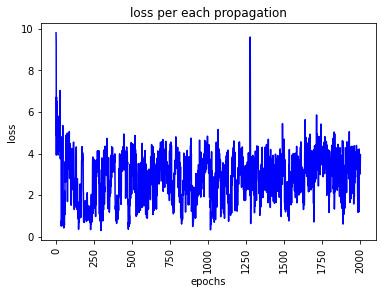

In [ ]:
plt.plot(losses, color = 'blue')
plt.xticks(rotation ='vertical')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss per each propagation")
plt.show()

##Evaluate:

In [ ]:
def evaluate(encoder, decoder, sentence_id, max_length=MAX_LENGTH):
    with torch.no_grad():
        print(f"poet is being : {tokenizer.decode(tokenized[2* sentence_id])}, {tokenizer.decode(tokenized[2* sentence_id+1])}")
        input_tensor = tensorFromSentence(input_lang, sentence_id,26).to(device)
        input_length = input_tensor.size()[0]
        hidden, cell = encoder.initHidden(1)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
          hidden, cell = encoder(input_tensor[ei], hidden, cell)

        x = torch.tensor([[tokenizer.bos_token_id]], device=device)

        decoded_words = []

        for di in range(max_length):
            decoder_output, hidden, cell = decoder(
                x, hidden, cell)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == tokenizer.eos_token_id:
                decoded_words.append('[EOS]')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

##generation

In [ ]:
for i in range(1,3):
  print(evaluate(encoder1,decoder1,i))
for i in range(1,3):
  print(evaluate(encoder1,decoder1,i))

poet is being : خداوند نام و خداوند جای, خداوند روزی ده رهنمای
['▁یکی', '▁بد', '▁بد', '▁بد', '▁که', '▁که', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁که', '▁بد', '[EOS]']
poet is being : خداوند کیوان و گردان سپهر, فروزنده ماه و ناهید و مهر
['▁یکی', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁که', '▁و', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁که', '▁بد', '[EOS]']
poet is being : خداوند نام و خداوند جای, خداوند روزی ده رهنمای
['▁یکی', '▁که', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁که', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁که', '▁بد', '▁بد', '▁که', '▁بد', '▁بد', '▁بد', '▁که', '▁بد', '▁بد', '<unk>', '<unk>', '[EOS]']
poet is being : خداوند کیوان و گردان سپهر, فروزنده ماه و ناهید و مهر
['▁یکی', '▁بد', '▁بد', '▁که', '▁که', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁که', '▁که', '▁بد', '▁بد', '▁که', '▁بد', '▁بد', '▁که', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁بد', '▁که', '▁که']


high overfitting problem is obvious, currently no solution comes to mind.<br/>

It does have the generative feature though

#Section 3: GRU

##Training subsection:

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout_p):
    super(Encoder, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.dropout = nn.Dropout(dropout_p)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.gru = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout_p)

  def forward(self, input,hidden):
    embedding = self.dropout(self.embedding(input)).view(1, 1, -1)
    output, hidden = self.gru(embedding, hidden)

    return hidden

  def initHidden(self,batch_size):
    return torch.zeros((self.num_layers, batch_size, self.hidden_size),device=device)

class Decoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout_p):
    super(Decoder, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.dropout = nn.Dropout(dropout_p)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.gru = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout_p)
    self.fc = nn.Linear(hidden_size, input_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    input = input.unsqueeze(0)

    embedding = self.dropout(self.embedding(input)).view(1, 1, -1)
    embedding = F.relu(embedding)
    output, hidden = self.gru(embedding,hidden)
    prediction = self.softmax(self.fc(output[0]))

    return prediction, hidden

In [ ]:
teacher_force_ratio = 0.5
MAX_LENGTH=27

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH, batch_size=1):
    encoder_hidden = encoder.initHidden(batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    batch_size = input_tensor.shape[1]
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)

    x = torch.tensor([[tokenizer.bos_token_id]], device=device)

    hidden = encoder_hidden

    for t in range(1, target_length):
      output, hidden = decoder(x, hidden)
      loss += criterion(output, target_tensor[t])
      best_guess = output.argmax(dim=1)
      x = target_tensor[t] if random.random()<teacher_force_ratio else best_guess
      if x.item() == tokenizer.eos_token_id:
        break


    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length



def trainIters(dataloader,encoder, decoder, n_iters, learning_rate=0.01,batch_size=1):
    losses = []
    accs = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
      epoch_loss = 0
      accuracy = 0
      count=0
      with tqdm(enumerate(dataloader),total=len(dataloader)) as pbar:
        for i,(X, y) in pbar:
          input_tensor = X.T.to(device)
          target_tensor = y.T.type(torch.LongTensor).to(device)

          loss = train(input_tensor, target_tensor, encoder,
                      decoder, encoder_optimizer, decoder_optimizer, criterion)

          epoch_loss += loss

          losses.append(loss)

          if (losses[-1]==min(losses)):
              torch.save(encoder.state_dict(), 'Ferdousi_gru_encoder.pth')
              torch.save(decoder.state_dict(), 'Ferdousi_gru_decoder.pth')

          pbar.set_description(f'EPOCH:{epoch+1} - Loss: {epoch_loss/(i+1):.4f}')
          count+=1
          if(count>1000):
            break
      return losses

In [ ]:
num_epochs = 1
learning_rate=1e-2
batch_size=1
input_size = po_persian.n_words
embedding_size = 128
hidden_size = 128
num_layers = 2
dropout=0.5

In [ ]:
encoder2 = Encoder(input_size, embedding_size, hidden_size, num_layers, dropout).to(device)
decoder2 = Decoder(input_size, embedding_size, hidden_size, num_layers, dropout).to(device)

losses = trainIters(train_dataloader,encoder2, decoder2, num_epochs, learning_rate=0.01,batch_size=1)

EPOCH:1 - Loss: 3.8400:   5%|▌         | 2000/39680 [01:43<32:32, 19.30it/s]


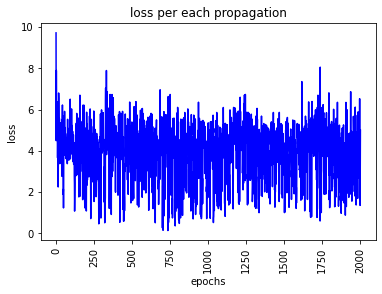

In [ ]:
plt.plot(losses, color = 'blue')
plt.xticks(rotation ='vertical')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss per each propagation")
plt.show()

##Generation

In [ ]:
def evaluate(encoder, decoder, sentence_id, max_length=MAX_LENGTH):
    with torch.no_grad():
        print(f"poet is being : {tokenizer.decode(tokenized[2* sentence_id])}, {tokenizer.decode(tokenized[2* sentence_id+1])}")
        input_tensor = tensorFromSentence(input_lang, sentence_id,26).to(device)
        input_length = input_tensor.size()[0]
        hidden = encoder.initHidden(1)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
          hidden= encoder(input_tensor[ei], hidden)

        x = torch.tensor([[tokenizer.bos_token_id]], device=device)

        decoded_words = []

        for di in range(max_length):
            decoder_output, hidden = decoder(
                x, hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == tokenizer.eos_token_id:
                decoded_words.append('[EOS]')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [ ]:
for i in range(30,32):
  print(evaluate(encoder2,decoder2,i))
for i in range(30,32):
  print(evaluate(encoder2,decoder2,i))

poet is being : تویی کردهٔ کردگار جهان, ببینی همی آشکار و نهان
['▁بدو', 'پرسد', 'پرسد', '▁زند', '[EOS]']
poet is being : به گفتار دانندگان راه جوی, به گیتی بپوی و به هر کس بگوی
['▁بدو', '▁زند', 'پرسد', 'پرسد', '<unk>', '<unk>', '<unk>', '[EOS]']
poet is being : تویی کردهٔ کردگار جهان, ببینی همی آشکار و نهان
['▁گریزان', '▁', '▁زند', 'پرسد', '[EOS]']
poet is being : به گفتار دانندگان راه جوی, به گیتی بپوی و به هر کس بگوی
['▁بدو', 'پرسد', '<unk>', '▁زند', '<unk>', '<unk>', '<unk>', '[EOS]']


GRU model has significantly better results.